In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Hyper parameters
num_epochs = 4
batch_size = 4   
learning_rate = 0.001

In [4]:
# Dataset has PIL images of range [0, 1]
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='./CIFAR', train=True,
                                            download=False, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./CIFAR', train=False,
                                            download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, shuffle=False)                                            

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

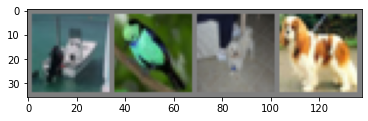

In [8]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [9]:
# Implement a convolutional neural network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x

model = ConvNet().to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2500 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, n_total_steps, loss.item()))

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/4], Step [2500/12500], Loss: 2.3144
Epoch [1/4], Step [5000/12500], Loss: 2.2573
Epoch [1/4], Step [7500/12500], Loss: 2.3890
Epoch [1/4], Step [10000/12500], Loss: 2.1533
Epoch [1/4], Step [12500/12500], Loss: 2.2164
Epoch [2/4], Step [2500/12500], Loss: 2.1444
Epoch [2/4], Step [5000/12500], Loss: 1.6325
Epoch [2/4], Step [7500/12500], Loss: 1.9186
Epoch [2/4], Step [10000/12500], Loss: 1.3968
Epoch [2/4], Step [12500/12500], Loss: 2.0000
Epoch [3/4], Step [2500/12500], Loss: 1.0453
Epoch [3/4], Step [5000/12500], Loss: 1.5450
Epoch [3/4], Step [7500/12500], Loss: 2.0447
Epoch [3/4], Step [10000/12500], Loss: 1.5430
Epoch [3/4], Step [12500/12500], Loss: 1.9879
Epoch [4/4], Step [2500/12500], Loss: 1.1652
Epoch [4/4], Step [5000/12500], Loss: 2.8137
Epoch [4/4], Step [7500/12500], Loss: 1.3365
Epoch [4/4], Step [10000/12500], Loss: 1.6382
Epoch [4/4], Step [12500/12500], Loss: 1.3734


In [12]:
print('Finished Training')
PATH = './model.pth'
torch.save(model.state_dict(), PATH)

Finished Training


In [13]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 45.41 %
Accuracy of plane: 55.2 %
Accuracy of car: 67.4 %
Accuracy of bird: 35.0 %
Accuracy of cat: 20.8 %
Accuracy of deer: 41.9 %
Accuracy of dog: 42.3 %
Accuracy of frog: 47.2 %
Accuracy of horse: 54.3 %
Accuracy of ship: 64.0 %
Accuracy of truck: 26.0 %
